In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shared import Benchmark, Run, Group

from pathlib import Path
from typing import List

def run_area(run: Run) -> int:
    return run.input_size.rows * run.input_size.columns

def sum_of_stage_means(run: Run, stages: List[str]):
    return sum((run.data[stage].mean() for stage in stages))

def sum_of_stage_medians(run: Run, stages: List[str]):
    return sum((run.data[stage].median() for stage in stages))

# Excludes data loading time
def runtime_mean(run: Run):
    return sum_of_stage_means(run, ["Prepare", "Transfer", "Run", "Finalize"])

def runtime_mean_without_prepare(run: Run):
    return sum_of_stage_means(run, ["Transfer", "Run", "Finalize"])

def area_to_dimensions_formatter(value, pos) -> str:
    side = np.sqrt(value)
    return f"{side}x{side}"

benchmark_path = Path.cwd().parent / "benchmarking" / "test" / "SingleVSDouble"
benchmark = Benchmark.load(benchmark_path)

class Groups:
    def __init__(self, single: Group, double: Group, input_type: str):
        self.single = single
        self.double = double
        self.input_type = input_type

single_groups = [group for group in benchmark.groups if "single" in group.name]

groups = []
for single in single_groups:
    input_type = re.match("single_(.+)", single.name).group(1)
    double = next(group for group in benchmark.groups if re.match(f"double_{input_type}", group.name))
    groups.append(Groups(single, double, input_type))


## Single vs Double

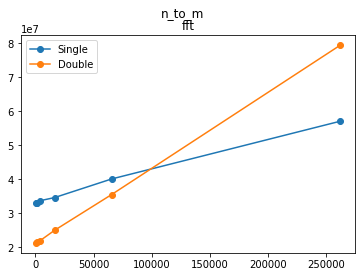

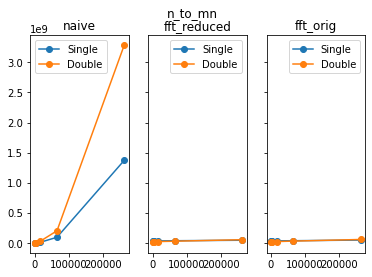

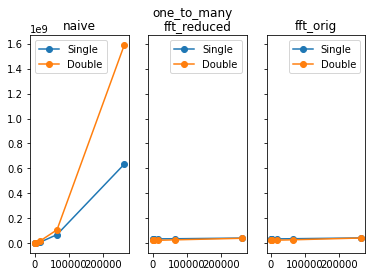

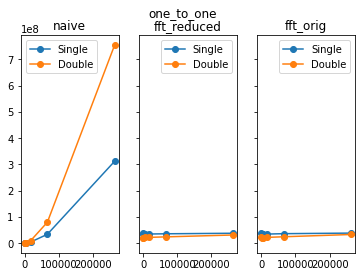

In [2]:

for group in groups:
    algorithm_names = set((run.name for run in group.single.runs))

    fig, axes = plt.subplots(1, len(algorithm_names), squeeze=False, sharey=True)
    fig.suptitle(group.input_type)
    for idx, alg_name in enumerate(algorithm_names):
        alg_single_runs = [run for run in group.single.runs if run.name == alg_name]
        alg_double_runs = [run for run in group.double.runs if run.name == alg_name]
        axes[0, idx].plot(
            [run_area(run) for run in alg_single_runs],
            [runtime_mean(run) for run in alg_single_runs],
            "o-",
            label="Single"
        )

        axes[0, idx].plot(
            [run_area(run) for run in alg_double_runs],
            [runtime_mean(run) for run in alg_double_runs],
            "o-",
            label="Double"
        )

        axes[0, idx].set_title(alg_name)
        # axes[0, idx].xaxis.set_major_formatter(area_to_dimensions_formatter)
        axes[0, idx].legend()





## Small naive vs fft

### The cost of prepare
Without the prepare step, the fft based algorithms win even for small datasets.

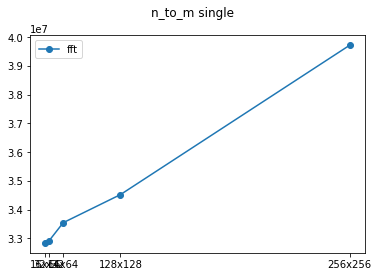

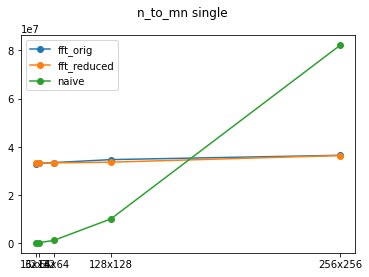

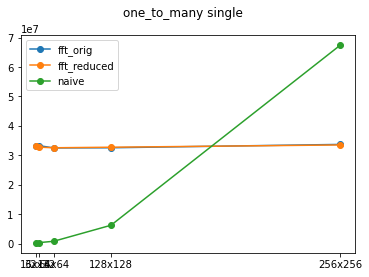

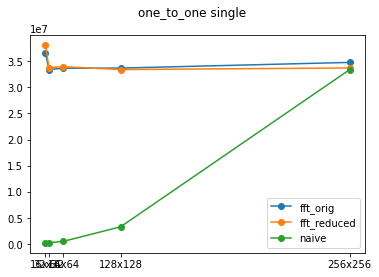

In [3]:
for group in groups:
    algorithm_names = set((run.name for run in group.single.runs))

    fig, ax = plt.subplots()
    fig.suptitle(f"{group.input_type} single")
    for alg_name in sorted(algorithm_names):
        alg_single_runs = [run for run in group.single.runs if run.name == alg_name and run.input_area() <= 256*256]
        ax.plot(
            [run.input_area() for run in alg_single_runs],
            [sum_of_stage_medians(run, ["Prepare", "Transfer", "Run", "Finalize"]) for run in alg_single_runs],
            "o-",
            label=f"{alg_name}"
        )

        ax.set_xticks([run.input_area() for run in alg_single_runs])
        ax.set_xticklabels([f"{run.input_size.rows}x{run.input_size.columns}" for run in alg_single_runs])
        ax.legend()

## Without the prepare step


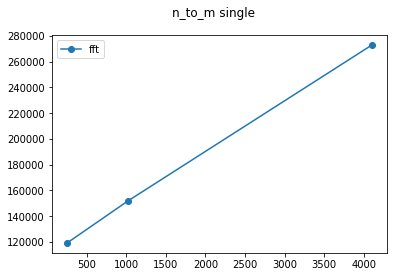

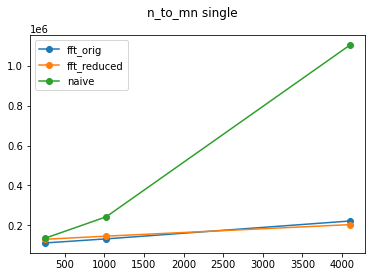

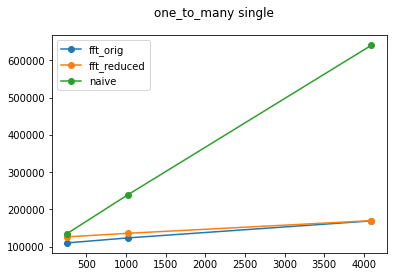

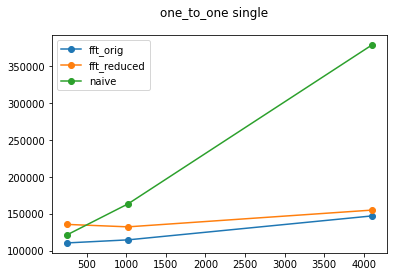

In [4]:
for group in groups:
    algorithm_names = set((run.name for run in group.single.runs))

    fig, ax = plt.subplots()
    fig.suptitle(f"{group.input_type} single")
    for alg_name in sorted(algorithm_names):
        alg_single_runs = [run for run in group.single.runs if run.name == alg_name and run.input_area() <= 64*64]
        ax.plot(
            [run_area(run) for run in alg_single_runs],
            [sum_of_stage_medians(run, ["Transfer", "Run", "Finalize"]) for run in alg_single_runs],
            "o-",
            label=f"{alg_name}"
        )

        #ax.xaxis.set_major_formatter(area_to_dimensions_formatter)
        ax.legend()

# Single vs Double FFT

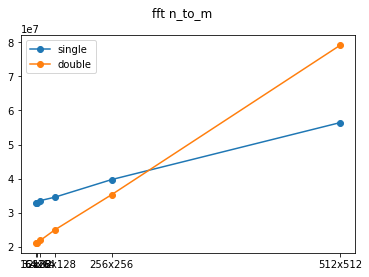

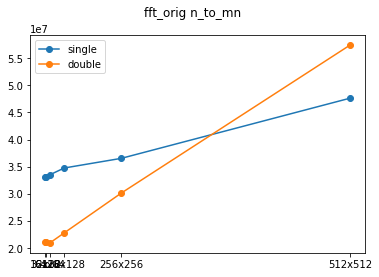

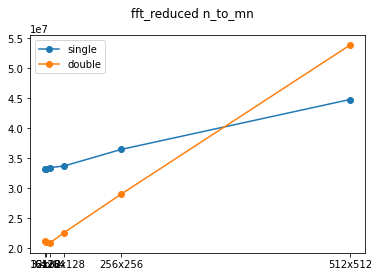

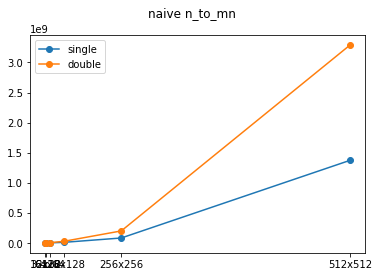

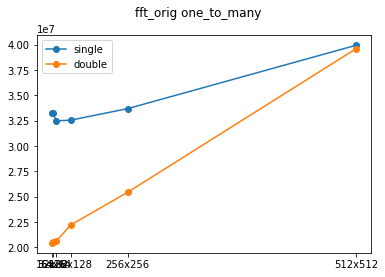

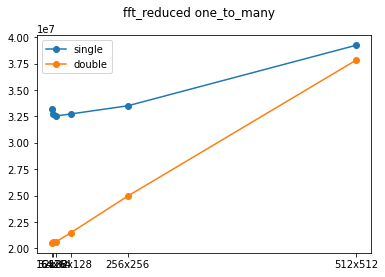

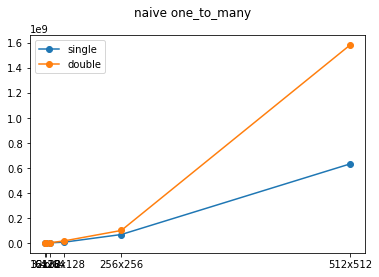

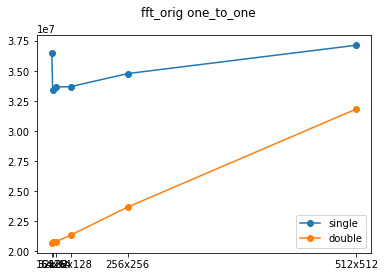

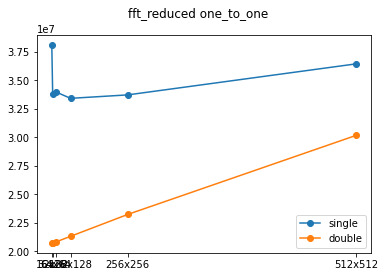

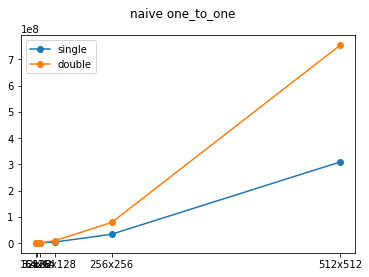

In [5]:
for group in groups:
    algorithm_names = set((run.name for run in group.single.runs))


    for alg_name in sorted(algorithm_names):
        alg_single_runs = [run for run in group.single.runs if run.name == alg_name]
        alg_double_runs = [run for run in group.double.runs if run.name == alg_name]
        fig, ax = plt.subplots()
        fig.suptitle(f"{alg_name} {group.input_type}")
        ax.plot(
            [run.input_area() for run in alg_single_runs],
            [sum_of_stage_medians(run, ["Prepare", "Transfer", "Run", "Finalize"]) for run in alg_single_runs],
            "o-",
            label=f"single"
        )
        ax.plot(
            [run.input_area() for run in alg_double_runs],
            [sum_of_stage_medians(run, ["Prepare", "Transfer", "Run", "Finalize"]) for run in alg_double_runs],
            "o-",
            label=f"double"
        )

        ax.set_xticks([run.input_area() for run in alg_single_runs])
        ax.set_xticklabels([f"{run.input_size.rows}x{run.input_size.columns}" for run in alg_single_runs])
        ax.legend()